# Tutorial 5, Question 1b

In [1]:
import torch
from torch import nn

import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold

In [2]:
no_labels = 1
no_features = 2
no_exps = 10

lr = 0.05
no_epochs = 5000
patience = 10
no_folds = 5

hidden_units = [2, 4, 6, 8, 10]

In [3]:
seed = 10
torch.manual_seed(seed)
np.random.seed(seed)

In [4]:
class MLP(nn.Module):
    def __init__(self, no_features, no_hidden, no_labels):
        super().__init__()
        self.mlp_stack = nn.Sequential(
            nn.Linear(no_features, no_hidden),
            nn.Sigmoid(),
            nn.Linear(no_hidden, no_labels),
        )

    def forward(self, x):
        logits = self.mlp_stack(x)
        return logits

In [5]:
class EarlyStopper:
    def __init__(self, patience=10, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [6]:
# perform experiments
def train_exp(X, Y):
    
    err = []
    cv = KFold(n_splits=no_folds, shuffle=True, random_state=1)
    
    for train_idx, test_idx in cv.split(X, Y):
        x_train, y_train  = X[train_idx], Y[train_idx]
        x_test, y_test = X[test_idx], Y[test_idx]

        err_ = []
        for no_hidden in hidden_units:

            model = MLP(no_features, no_hidden, no_labels)
    
            loss_fn = torch.nn.MSELoss()
            optimizer = torch.optim.SGD(model.parameters(), lr=lr)
            early_stopper = EarlyStopper(patience=patience, min_delta=0)
        
            for epoch in range(no_epochs):
                pred = model(torch.tensor(x_train, dtype=torch.float))
                train_loss = loss_fn(pred, torch.tensor(y_train, dtype=torch.float))
    
                # Backpropagation
                optimizer.zero_grad()
                train_loss.backward()
                optimizer.step()
        
                pred = model(torch.tensor(x_test, dtype=torch.float))
                test_loss = loss_fn(pred, torch.tensor(y_test, dtype=torch.float))
            
                if early_stopper.early_stop(test_loss): 
                    break
                    
            err_.append(test_loss.item())
                
        err.append(err_)

    cv_err = np.mean(np.array(err), axis = 0)

    return cv_err

In [7]:
# generate training data
X = np.zeros((10*10, 2))
no_data = 0
for i in np.arange(-1.0, 1.001, 2.0/9.0):
    for j in np.arange(-1.0, 1.001, 2.0/9.0):
        X[no_data] = [i, j]
        no_data += 1
Y = np.zeros((no_data, 1))
Y[:,0] = np.sin(np.pi*X[:,0])*np.cos(2*np.pi*X[:,1])

In [8]:
idx = np.arange(no_data)

# perform experiments
err = []
print('hidden units: {}'.format(hidden_units))
for exp in range(no_exps):
 
    np.random.shuffle(idx)
    err.append(train_exp(X[idx], Y[idx]))
    print('exp: {}, errors: {}'.format(exp, np.array(err[exp])))

hidden units: [2, 4, 6, 8, 10]
exp: 0, errors: [0.24425552 0.24785744 0.24786258 0.2485362  0.2486934 ]
exp: 1, errors: [0.26322764 0.25604886 0.26049736 0.25774734 0.26014432]
exp: 2, errors: [0.24648174 0.24945401 0.24925065 0.2541023  0.25359546]
exp: 3, errors: [0.25059584 0.25660435 0.25144399 0.24931019 0.24994032]
exp: 4, errors: [0.2476077  0.24997003 0.24755693 0.24637382 0.25181153]
exp: 5, errors: [0.25033807 0.24913572 0.25795741 0.25433005 0.25504953]
exp: 6, errors: [0.25974986 0.25432905 0.2574923  0.25529798 0.25813778]
exp: 7, errors: [0.24935909 0.24378973 0.25170192 0.25607452 0.24589538]
exp: 8, errors: [0.2561734  0.25065661 0.24924175 0.2470926  0.25064278]
exp: 9, errors: [0.24914538 0.25445358 0.25787997 0.25906916 0.25242117]


In [9]:
# print the mean errors of different models
mean_err = np.mean(np.array(err), axis = 0)
print('mean errors: {}'.format(mean_err))
print(' *hidden units* %d '%hidden_units[np.argmin(mean_err)])

mean errors: [0.25169342 0.25122994 0.25308848 0.25279342 0.25263317]
 *hidden units* 4 


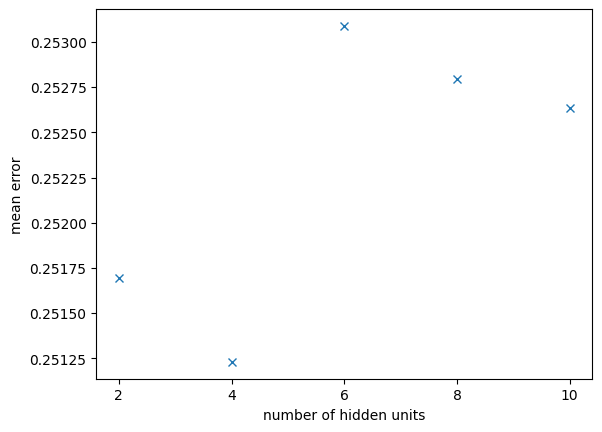

In [10]:
plt.figure(1)
plt.plot(hidden_units, mean_err, marker = 'x', linestyle = 'None')
plt.xticks(hidden_units)
plt.xlabel('number of hidden units')
plt.ylabel('mean error')
plt.show()